In [1]:
import numpy as np
import random

from keras.layers import Input,merge
from keras.layers.core import Reshape, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Cropping2D, Convolution2D, Deconvolution2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
import keras
from keras.models import Model

from tqdm import tqdm


Using Theano backend.
Using gpu device 0: GeForce 820M (CNMeM is disabled, cuDNN not available)


In [53]:
import pickle
def load_data(path):
    with open(path,'rb') as f:
        Xs,Ys = pickle.load(f)
    Xs.shape = (60000, 3, 32, 32)
    Xs = Xs.astype('float32')
    return Xs,Ys

Xs,Ys = load_data('agg_data')

In [100]:
Xs /= 255

In [54]:
import vis_utils
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
def vis_grid(Xs):
    # this is a proxy for vis_utils.vis_grid. Since this script use theano order (3,32,32), but the vis_utils one use (32,32,3)
    return vis_utils.vis_grid(Xs.transpose(0,2,3,1))

In [56]:
Xs.shape,Ys.shape

((60000, 3, 32, 32), (60000,))

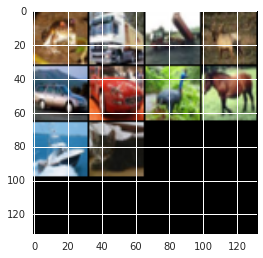

In [101]:
plt.imshow(vis_grid(Xs[:10]))

100d noise + 10d onehot -> generator -> (32,32) -> discriminator -> 10d real class + 10d fake class

In [9]:
# define network, the origin version is in https://github.com/dremovd/yadcgan-keras/blob/master/DCGAN.ipynb

noise_dim = 100
use_class = 10

def generator_block(input_node, input_shape, leaku_relu_alpha) :    
    channels, height, width = input_shape
    output_shape = (None, channels // 2, height * 2 + 2, width * 2 + 2)  
    
    block = Deconvolution2D(
        output_shape[1], 
        4, 4, 
        output_shape = output_shape, 
        border_mode='valid', 
        init='glorot_uniform', 
        subsample = (2, 2),
    )(input_node)
    block = Cropping2D(((1, 1), (1, 1)))(block)
    block = BatchNormalization(mode = 2)(block)
    block = LeakyReLU(leaku_relu_alpha)(block)

    return block

def build_generator(initial_size , channels_count = 8 * 8, leaky_relu_alpha = 0.2) :
    generator_input = Input(shape=[noise_dim + use_class])
    
    initial_height, initial_width = initial_size
    
    H = Dense(channels_count * initial_height * initial_width * 4, init='glorot_normal')(generator_input)
    H = BatchNormalization(mode = 2)(H)
    H = LeakyReLU(0.2)(H)
    
    H = Dense(channels_count * initial_height * initial_width, init='glorot_normal')(H)
    H = BatchNormalization(mode = 2)(H)
    H = LeakyReLU(0.2)(H)
    
    H = Reshape([channels_count, initial_height, initial_width] )(H) # nch

    H = generator_block(H, (channels_count, initial_height, initial_width), leaky_relu_alpha)
    H = generator_block(H, (channels_count // 2 , initial_height * 2, initial_width * 2), leaky_relu_alpha)
    H = generator_block(H, (channels_count // 4 , initial_height * 4, initial_width * 4), leaky_relu_alpha)
    #H = generator_block(H, (channels_count // 8 , initial_height * 8, initial_width * 8), leaky_relu_alpha)

    H = Convolution2D(channels_count // 32, 3, 3, border_mode='same', init='glorot_uniform')(H)
    H = BatchNormalization(mode = 2)(H)
    H = LeakyReLU(leaky_relu_alpha)(H)

    H = Convolution2D(3, 1, 1, border_mode='same', init='glorot_uniform')(H)
    generator_output = Activation('tanh')(H)

    generator = Model(generator_input, generator_output)
    generator_output_shape = (3, 32, 32)

    return generator, generator_input, generator_output_shape


def build_discriminator(input_shape, discriminator_base_channels = 64, leaky_relu_alpha = 0.2, dropout_rate = 0.25) :
    discriminator_input = Input(shape = input_shape)
    H = Convolution2D(discriminator_base_channels * 3, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(discriminator_input)
    H = LeakyReLU(leaky_relu_alpha)(H)
    H = Dropout(dropout_rate)(H)
    
    H = Convolution2D(discriminator_base_channels * 4, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
    H = LeakyReLU(leaky_relu_alpha)(H)
    H = Dropout(dropout_rate)(H)
    
    H = Convolution2D(discriminator_base_channels * 6, 3, 3, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
    H = LeakyReLU(leaky_relu_alpha)(H)
    H = Dropout(dropout_rate)(H)
    
    H = Convolution2D(discriminator_base_channels * 3, 1, 1, border_mode = 'same', activation='relu')(H)
    H = LeakyReLU(leaky_relu_alpha)(H)
    H = Dropout(dropout_rate)(H)
    H = Flatten()(H)
    
    H = Dense(discriminator_base_channels * 2)(H)
    H = LeakyReLU(0.2)(H)
    discriminator_output = Dense(20, activation='softmax')(H)
    
    discriminator = Model(discriminator_input, discriminator_output)
    return discriminator, discriminator_output

def make_trainable(model, mode):
    model.trainable = mode
    for layer in model.layers:
        layer.trainable = mode
    
    
def build_models(
    debug = True, 
    generator_optimizer = Adam(lr = 5e-4), 
    discriminator_optimizer = SGD(lr=5e-3, momentum = 0.9),
    discriminator_dropout_rate = 0.25,
    generator_initial_size = (4, 4),
) :
    generator, generator_input, generator_output_shape = build_generator(generator_initial_size) 
    generator.compile(loss='categorical_crossentropy', optimizer = generator_optimizer)

    if debug :
        generator.summary()
    
    discriminator, discriminator_output = build_discriminator(generator_output_shape, dropout_rate = discriminator_dropout_rate)
    discriminator.compile(loss='categorical_crossentropy', optimizer = discriminator_optimizer)
    if debug :
        discriminator.summary()
        
    # Freeze weights in the discriminator for stacked training
    make_trainable(discriminator, False)
    
    gan_input = Input(shape=[noise_dim + use_class])
    H = generator(gan_input)
    gan_output = discriminator(H)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='categorical_crossentropy', optimizer=generator_optimizer)
    if debug :
        gan.summary()
        
    return generator, discriminator, gan, generator_optimizer, discriminator_optimizer

In [12]:
%%time
generator, discriminator, gan, generator_optimizer, discriminator_optimizer = build_models(debug = False)

Wall time: 3.79 s


In [13]:
generator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 110)           0                                            
____________________________________________________________________________________________________
dense_9 (Dense)                  (None, 4096)          454656      input_5[0][0]                    
____________________________________________________________________________________________________
batchnormalization_13 (BatchNorm (None, 4096)          16384       dense_9[0][0]                    
____________________________________________________________________________________________________
leakyrelu_23 (LeakyReLU)         (None, 4096)          0           batchnormalization_13[0][0]      
___________________________________________________________________________________________

In [14]:
discriminator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 3, 32, 32)     0                                            
____________________________________________________________________________________________________
convolution2d_15 (Convolution2D) (None, 192, 16, 16)   14592       input_6[0][0]                    
____________________________________________________________________________________________________
leakyrelu_29 (LeakyReLU)         (None, 192, 16, 16)   0           convolution2d_15[0][0]           
____________________________________________________________________________________________________
dropout_9 (Dropout)              (None, 192, 16, 16)   0           leakyrelu_29[0][0]               
___________________________________________________________________________________________

In [15]:
gan.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 110)           0                                            
____________________________________________________________________________________________________
model_5 (Model)                  (None, 3, 32, 32)     4714035     input_7[0][0]                    
____________________________________________________________________________________________________
model_6 (Model)                  (None, 20)            2598612     model_5[1][0]                    
Total params: 7,312,647
Trainable params: 4,703,619
Non-trainable params: 2,609,028
____________________________________________________________________________________________________


In [85]:
def cond_generator(batch, of_class) :
    # batch = 4, of_class = [1,2,2,0]
    # Normal (0, 1) noise instead of uniform as in original DCGAN 
    of_class = np.array(of_class) + noise_dim
    cond = np.zeros((batch, noise_dim + use_class))
    cond[:, :noise_dim] = np.random.normal(0, 1, size = [batch, noise_dim])
    cond[np.arange(batch), of_class] = 1
    return cond

def fake_generator(batch):
    of_class = np.random.randint(0, use_class, size = batch)
    cond = cond_generator(batch, of_class)
    return cond, of_class

In [86]:
def pretrain_discriminator(discriminator, X, Y, pretrain_size = 10000) :
    train_ids = random.sample(range(0, X.shape[0]), pretrain_size)
    X_pretrain = X[train_ids, :, :, :]
    Y_pretrain = Y[train_ids]

    #of_class = np.random.randint(0, use_class, size = pretrain_size)
    #cond = cond_generator(pretrain_size, of_class)
    cond, of_class = fake_generator(pretrain_size)
    generated_images = generator.predict(cond)
    X_pretrain = np.concatenate([X_pretrain, generated_images])

    y = np.zeros([pretrain_size * 2, use_class * 2])
    # Real images
    y[np.arange(pretrain_size), Y_pretrain] = 1
    # Generated
    y[np.arange(pretrain_size) + pretrain_size, of_class + use_class] = 1

    make_trainable(discriminator, True)
    discriminator.fit(X_pretrain, y, nb_epoch=2, batch_size=256, verbose = 0)
    return discriminator.evaluate(X_pretrain, y, verbose = 0)


In [87]:
%%time

pretrain_discriminator(discriminator, Xs, Ys)


Wall time: 9min 32s


15.317831848144531

In [116]:
def history_replay(history_images_list, history_classes_list, batch_size) :
    assert len(history_images_list) == len(history_classes_list)
    assert len(history_images_list) % len(history_images_list) == 0
    
    history_images_batch = []
    history_classes_batch = []
    for history_images, history_classes in zip(history_images_list, history_classes_list) :
        count = batch_size // len(history_images_list)
        index = np.random.randint(0, history_images.shape[0], size = count)
        history_images_batch.append(history_images[index])
        history_classes_batch.append(history_classes[index])
    images_batch = np.concatenate(history_images_batch)
    classes_batch = np.concatenate(history_classes_batch)
    return images_batch, classes_batch

In [108]:
def train_discriminator(discriminator, history_images_list, history_classes_list, X, Y, batch_size, losses) :
    make_trainable(discriminator, True)

    X_fake, y_fake = history_replay(history_images_list, history_classes_list, batch_size) # y_fake is ids not the onehot matrix
    y = np.zeros([batch_size, 2 * use_class])
    
    # Soft-noisy labels
    #y[range(len(y)), ] = np.random.uniform(0.7, 1.0, size=[batch_size])
    #y[:, 1] = -y[:, 0] + 1.0
    soft_noisy = np.random.uniform(0.7, 1.0, size = [batch_size])
    y[np.arange(y.shape[0]), y_fake + use_class] = soft_noisy
    y[np.arange(y.shape[0]), y_fake] = 1 - soft_noisy
    
    loss_fake = discriminator.train_on_batch(X_fake, y)
    
    idx = np.random.randint(0, X.shape[0],size = batch_size)
    X_real = X[idx,:,:,:]
    y_real = Y[idx]
    y = np.zeros([batch_size, use_class * 2])
    soft_noisy = np.random.uniform(0.7, 1.0, size = [batch_size])
    y[np.arange(y.shape[0]), y_real] = soft_noisy
    y[np.arange(y.shape[0]), y_real + use_class] = 1 - soft_noisy
    #y[:, 1] = np.random.uniform(0.7, 1.2, size=[batch_size])
    #y[:, 0] = -y[:, 1] + 1.0
    
    loss_real  = discriminator.train_on_batch(X_real, y)
    for name, loss in [
        ('discriminator logloss real', loss_real),
        ('discriminator logloss fake', loss_fake),
    ] :
        losses[name].append(loss)

        
def train_generator(gan, generator, batch_size, losses) :
    g_loss = 0
    make_trainable(discriminator, False)
    cond, y_fake = fake_generator(batch_size)
    y = np.zeros([batch_size,  use_class * 2])
    y[np.arange(y.shape[0]), y_fake] = 1 # use false setting to attract network.

    loss = gan.train_on_batch(cond, y)
    for name, loss in [
        ('generator logloss', loss),
    ] :
        losses[name].append(loss)

# This code is not compatible between linux and windows
#!mkdir samples
#!mkdir samples/cifar
#!mkdir samples/cifar/shaking

import os
os.makedirs('samples', exist_ok = True)
os.makedirs('samples/cifar', exist_ok = True)
os.makedirs('samples/cifar/shaking', exist_ok = True)
        
rows, columns = 9, 9

def save_models(generator, discriminator, gan) :
    #generator.save('generator.model')
    #discriminator.save('discriminator.model')
    gan.save('gan.model')
    
def train_gan(discriminator, gan, generator, losses, epoch_count = 50000, plot_frequency = 50, render_frequency = 1000, 
              batch_size = 32, history_length = 8) :
    # History replay-like heuristic used to train discriminator 
    history_images_list = []
    history_classes_list = []
    
    #for i in range(history_length - 1) : 
    while len(history_images_list) < history_length:
        cond, y_fake = fake_generator(batch_size)
        generated_images = generator.predict(cond)    
        history_images_list.append(generated_images)
        history_classes_list.append(y_fake)
        
    for epoch in tqdm(range(epoch_count)) :
        #noise_gen = np.random.uniform(0, 1, size=[batch_size,100])
        idx = random.choice(range(history_length))
        history_images_list.pop(idx)
        history_classes_list.pop(idx)
        
        cond, y_fake = fake_generator(batch_size)
        generated_images = generator.predict(cond)
        history_images_list.append(generated_images)
        history_classes_list.append(y_fake)
        
        train_discriminator(discriminator, history_images_list, history_classes_list, Xs, Ys, batch_size, losses)
        train_generator(gan, generator, batch_size, losses)
        
        if epoch % plot_frequency == 0 :
            plot_loss(losses)
            plot_generator()
        '''
        if epoch % render_frequency == 0 :
            images = image_shaking(generator, images_count = rows, shakes_count = columns, noise = fixed_X_fake[:rows])
            save_tiled(
                images, 
                'samples/cifar/shaking/epoch-%d.png' % epoch, 
                rows, 
                columns,
                image_size = (48, 48)
            )
            save_models(generator, discriminator, gan)
        '''

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

import pandas as pd
#pandas used to efficiently calculate rolling_mean

def plot_loss(
    losses, 
    names = (
        'discriminator logloss real',
        'discriminator logloss fake',
        'generator accuracy',
        'generator logloss',
    ),
    average_window = 100,
):
    display.clear_output(wait = True)
    display.display(plt.gcf())
    plt.figure(figsize=(12, 8))
    for name in names :
        plt.plot(
            pd.rolling_mean(pd.Series(losses[name]), window = average_window).values, 
            label = name
        )
    
    plt.legend()
    plt.show()
    
def plot_grid(images, dimensions = (5, 5), figsize=(10, 10)) :
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dimensions[0], dimensions[1], i + 1)
        
        # (-1, 1) color range to (0, 1)
        image = (images[i, :, :, :] + 1.0) * 0.5
        
        plt.imshow(image)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

plot_dimensions = (5, 5)
plot_image_count = np.prod(plot_dimensions)
fixed_X_fake, fixed_y_fake = fake_generator(plot_image_count)

def plot_generator(n_images = plot_image_count, dimensions = plot_dimensions, figsize = (10, 10), fixed_set = True):
    if fixed_set :
        cond, y_fake = fake_generator(n_ex)
    else :
        cond, y_fake = fake_generator(n_ex)
        
    generated_images = generator.predict(cond)
    
    # Convert to (height, width, RGB)
    generated_images = np.swapaxes(generated_images, 1, 2)
    generated_images = np.swapaxes(generated_images, 2, 3)
    
    plot_grid(generated_images, plot_dimensions, figsize)
    


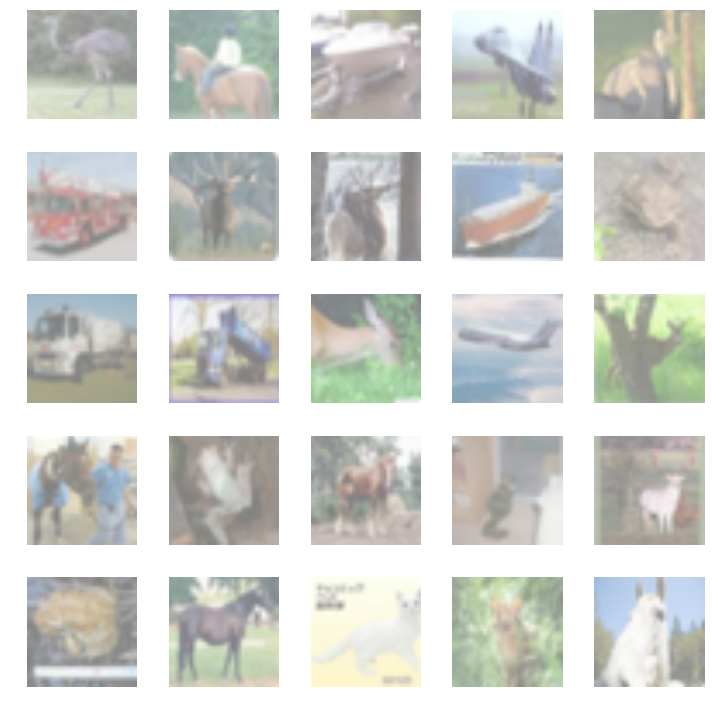

In [102]:
plot_dimensions = (5, 5)
plot_image_count = np.prod(plot_dimensions)

def plot_real(X, images_count = plot_image_count, dimensions = plot_dimensions, figsize=(10,10)):
    images_ids = np.random.randint(0, X.shape[0], images_count)
    images = X[images_ids, :, :, :][:, :, :, :]
    
    
    images = np.swapaxes(images, 1, 2)
    images = np.swapaxes(images, 2, 3)
    
    plot_grid(images, dimensions = dimensions)
    
plot_real(Xs)

In [103]:
def swap_dimensions(images) :
    images = np.swapaxes(images, 1, 2)
    images = np.swapaxes(images, 2, 3)
    return images

def shake(v, rate = 0.1) :
    return v * np.random.uniform(1.0 - rate, 1.0 + rate, size=100)


def image_shaking(generator, images_count = 9, shakes_count = 9, cond = None) :
    if cond is None :
        cond, y_fake = fake_generator(images_count)
    
    input_vectors = []
    for i in range(images_count) :        
        for j in range(shakes_count) :
            original = np.array(cond[i])
            if i > 0 :
                shaked = shake(original, 0.3)
            else :
                shaked = original
                
            input_vectors.append(shaked)
    
    input_vectors = np.stack(input_vectors)
    generated_images = generator.predict(input_vectors, batch_size = images_count * shakes_count)
    generated_images = np.swapaxes(generated_images, 1, 2)
    generated_images = np.swapaxes(generated_images, 2, 3)
    generated_images = (generated_images + 1.0) * 0.5
        
    return generated_images

In [104]:
losses = dict([
    (name, []) for name in (
        'discriminator logloss real',
        'discriminator logloss fake',
        'generator logloss',
    )
])
losses


{'discriminator logloss fake': [],
 'discriminator logloss real': [],
 'generator logloss': []}

In [117]:
train_gan(discriminator, gan, generator, losses, epoch_count = 50000, plot_frequency = 200, batch_size=32)


  0%|                                                | 0/50000 [00:00<?, ?it/s]DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/yiyuezhuo/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpm1xufzru/mb0fa03161c06f80947f33f3e08170f15.lib and object C:/Users/yiyuezhuo/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpm1xufzru/mb0fa03161c06f80947f33f3e08170f15.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/yiyuezhuo/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpjg4tdbno/mbbc6a35dc26cfc7bd76670bddb009dfc.lib and object C:/Users/yiyuezhuo/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpjg4tdbno/mbbc6a35dc26cfc7bd76670bddb009dfc.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/yiyuezhuo/AppData/

KeyboardInterrupt: 